# Part 7.1 - Applying Regression
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
#from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

[('spark.driver.port', '39752'),
 ('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1548506816283'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.driver.maxResultSize', '4g')]


<SparkContext master=local[*] appName=local>

**In this part we will apply linear regression on topic modeling result files to find with time goes there are correlations between topics or not.**

## 1 Load Data

**Load metadata:**

In [2]:
df_meta = load_dataset('meta', spark).select(F.col('id').alias('id_'), F.col('region'), F.col('date'))
df_meta.cache()

DataFrame[id_: int, region: string, date: date]

In [3]:
df_meta.limit(5).toPandas().head()

,id_,region,date
0,1854215,Auckland,1862-06-14
1,1854221,Auckland,1862-06-14
2,1854224,Auckland,1862-07-03
3,1854233,Auckland,1863-08-01
4,1854245,Auckland,1863-09-01


**Topic List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic', 'weight', 'keywords'],
                           encoding='utf8')
             .sort_values(by='topic')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

In [5]:
print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic,weight,keywords
139,139,0.01055,column advertisements free advt wellington powder good made soap street patent bottle write brand makes british wate...
92,92,0.01398,captain vessel ship steamer boat sea board crew port water passengers island time left boats wreck ashore made cargo...
158,158,0.00141,watch watches english stewart gold dawson silver levers lever hunting price ladies worth keyless prices waterbury po...
55,55,0.00670,wool market london sales new_zealand prices bales cent wheat mutton good demand australian firm beef sold received t...
44,44,0.00778,enemy german germans front french london british fighting troops attack received captured russian artillery line sta...


**Load doc-topic matrix:**

In [6]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id')
df_doctopic.cache();

In [7]:
print('Shape of dataframe:({}, {})'.format(df_doctopic.count(), len(df_doctopic.columns)))
df_doctopic.limit(5).toPandas().head()

Shape of dataframe:(1814086, 201)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1854215,0.000033,0.000132,0.000118,0.000131,0.000171,0.000668,0.000116,0.000187,0.000273,0.000064,0.000112,0.000099,0.000060,0.000059,0.000085,0.000147,0.000094,0.000080,0.000199,0.000119,0.000104,0.000062,0.000165,0.000138,0.000107,0.000165,0.000194,0.000101,0.017802,0.000194,0.000138,0.000077,0.000127,0.000134,0.000149,0.000070,0.000114,0.000213,0.000095,0.000208,0.000109,0.000036,0.000136,0.000133,0.000133,0.000115,0.000147,0.000116,0.000129,0.000086,0.000236,0.000124,0.000107,0.000105,0.000113,0.000115,0.000103,0.000175,0.000157,...,0.000030,0.000227,0.000114,0.000099,0.000075,0.000087,0.000079,0.000069,0.017168,0.000104,0.000114,0.000138,0.000066,0.000118,0.000102,0.000109,0.000042,0.000033,0.000024,0.000101,0.000105,0.000043,0.000095,0.000189,0.000315,0.000096,0.000114,0.000144,0.000021,0.000219,0.273583,0.000145,0.000116,0.000110,0.000030,0.000141,0.000284,0.000111,0.000225,0.000189,0.000117,0.000084,0.000116,0.000089,0.000220,0.000031,0.000224,0.000171,0.000076,0.000103,0.000158,0.000101,0.000052,0.000181,0.000127,0.000154,0.000169,0.000111,0.000106,0.000110
1,1854221,0.000047,0.000186,0.000166,0.000184,0.000240,0.000942,0.000163,0.000264,0.000384,0.000090,0.000158,0.000140,0.000085,0.000083,0.000120,0.000207,0.000133,0.000113,0.000280,0.000167,0.000146,0.000088,0.000233,0.000194,0.000151,0.000232,0.000274,0.000142,0.025093,0.000273,0.000194,0.000109,0.000179,0.000190,0.000210,0.000099,0.000160,0.000300,0.000134,0.000293,0.000154,0.000050,0.000191,0.000187,0.000187,0.000162,0.000207,0.000164,0.000182,0.000121,0.000333,0.000175,0.000151,0.000147,0.000159,0.000162,0.000145,0.000246,0.000221,...,0.000042,0.000320,0.000161,0.000139,0.000106,0.000122,0.000112,0.000098,0.000108,0.000147,0.000161,0.000194,0.000092,0.000167,0.000143,0.000154,0.000059,0.000047,0.000034,0.000142,0.000148,0.000060,0.000134,0.000266,0.000443,0.000135,0.000160,0.000203,0.000029,0.000309,0.000164,0.000205,0.000163,0.915641,0.000042,0.000199,0.000401,0.000156,0.000318,0.000266,0.000166,0.000118,0.000164,0.000125,0.000310,0.000043,0.000316,0.000241,0.000107,0.000145,0.000223,0.000143,0.000074,0.000255,0.000179,0.000218,0.000238,0.000157,0.000150,0.000155
2,1854224,0.000044,0.000174,0.000155,0.067575,0.000224,0.000878,0.000152,0.000246,0.000358,0.000084,0.000147,0.000131,0.000079,0.000077,0.000112,0.000193,0.000124,0.000106,0.000261,0.000156,0.000137,0.000082,0.000217,0.000181,0.000141,0.000216,0.000256,0.000133,0.000934,0.000255,0.000181,0.000102,0.000167,0.000177,0.000196,0.000092,0.000150,0.000280,0.000125,0.000273,0.000143,0.000047,0.000179,0.000175,0.000175,0.000151,0.000193,0.000153,0.000169,0.000113,0.000311,0.000163,0.000141,0.000137,0.000148,0.000151,0.000135,0.000230,0.000206,...,0.000039,0.000299,0.000150,0.000130,0.000099,0.000114,0.000104,0.000091,0.000100,0.000137,0.000150,0.000181,0.000086,0.000155,0.000133,0.000143,0.000055,0.000044,0.000032,0.000133,0.000138,0.000056,0.000125,0.000248,0.000414,0.000126,0.000149,0.000189,0.000027,0.000288,0.000153,0.000191,0.000152,0.876392,0.000040,0.000185,0.000374,0.000145,0.000296,0.000248,0.000154,0.000111,0.000153,0.000117,0.000290,0.000040,0.000295,0.000225,0.000100,0.000136,0.000208,0.000133,0.000069,0.000238,0.000167,0.000203,0.000222,0.000146,0.000140,0.000145
3,1854233,0.000013,0.000053,0.000047,0.000052,0.000068,0.000267,0.000046,0.000075,0.409643,0.102409,0.000045,0.000040,0.000024,0.000024,0.000034,0.000059,0.000038,0.000032,0.000079,0.000047,0.000041,0.081932,0.000066,0.034183,0.000043,0.000066,0.000078,0.000040,0.000284,0.000077,0.000055,0.000031,0.000051,0.000054,0.000060,0.000

## 2 Generate Dataset for Regression

**The result files of MALLET can not be used to regress directly, we need to generate a dataset for regressiong. The dataset consists of all topics, the weight of each topic is a feature, each observor/sample/row is a time unit. To sample more observor, we take month as the time unit.**

**Generate weight-month matrix:**

In [8]:
df = (df_doctopic
      .join(df_meta, df_doctopic.id == df_meta.id_)
      .withColumn('time', F.date_format('date', 'yyyy-MM'))
      .drop('id')
      .drop('id_')
      .drop('region')
      .drop('date')
      .orderBy('time')
      .groupBy('time')
      .sum()    
      .drop('time')
      )

df = df.toPandas()

columns = [str(x) for x in list(range(topic_number))]
df.columns = columns

print('Shape of dataframe:', df.shape)

df.head()

Shape of dataframe: (1234, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.000011,0.000045,0.000040,0.000044,0.000058,0.000227,0.000039,0.000064,0.163076,0.000022,0.000038,0.000034,0.000021,0.000020,0.000029,0.000050,0.000032,0.000027,0.000068,0.000040,0.000035,0.000021,0.000056,0.000047,0.000036,0.000056,0.000066,0.000034,0.000241,0.013648,0.006838,0.000026,0.000043,0.000046,0.000051,0.000024,0.000039,0.000072,0.000032,0.000071,0.000037,0.000012,0.000046,0.000045,0.000045,0.000039,0.000050,0.036227,0.000044,0.000029,0.000080,0.000042,0.000036,0.000036,0.269888,0.000039,0.463235,0.000059,0.000053,0.000035,...,0.000010,0.000077,0.000039,0.000034,0.000026,0.000029,0.000027,0.000024,0.000026,0.000035,0.000039,0.000047,0.000022,0.000040,0.000035,0.000037,0.000014,0.000011,0.000008,0.000034,0.000036,0.000015,0.000032,0.000064,0.000107,0.000033,0.000039,0.000049,0.000007,0.000075,0.000040,0.000049,0.000039,0.000037,0.000010,0.000048,0.026634,0.000038,0.000077,0.000064,0.000040,0.000029,0.000040,0.000030,0.000075,0.000010,0.000076,0.000058,0.000026,0.000035,0.000054,0.112086,0.000018,0.002474,0.000043,0.000052,0.000057,0.000038,0.284711,0.033812
1,0.000077,0.000306,0.000273,0.000302,0.000395,0.001547,0.000268,0.000433,0.180352,0.000148,0.000259,0.000230,0.010722,0.057277,0.067215,0.000340,0.006312,0.355273,0.005655,0.000275,0.000241,0.000144,0.000382,0.000319,0.000248,0.000381,0.000450,0.000234,0.016878,0.000448,0.000319,0.000179,0.000294,0.000312,0.000346,0.000162,0.000264,0.000494,0.312908,0.193737,0.000252,0.000082,0.000315,0.000308,0.016870,0.037531,0.321671,0.133111,0.000298,0.000199,0.000547,0.000288,0.000248,0.000242,0.616898,0.000265,0.363859,0.018683,0.000363,0.000238,...,0.000068,0.336925,0.000265,0.000229,0.000174,0.000201,0.000184,0.000161,0.000177,0.000242,0.000264,0.000319,0.000152,0.000274,0.003762,0.000252,0.000097,0.000078,0.000056,0.000234,0.143558,0.000099,0.000221,0.000437,0.000729,0.000222,0.000263,0.000333,0.000048,0.000508,0.285975,0.010725,0.067609,0.000255,0.000070,0.000327,0.000658,0.000256,0.000522,0.072849,0.000272,0.000195,0.008551,0.000206,0.000510,0.000071,0.038600,0.000397,0.026149,0.000239,0.000366,0.000235,0.000121,0.000419,0.065245,0.000358,0.000391,0.000257,0.000247,0.000255
2,0.000190,0.000757,0.033668,0.000748,0.013039,0.003825,0.003074,0.001071,0.580319,0.053788,0.000640,0.000569,0.000346,0.000337,0.034591,0.000840,0.000541,0.000460,0.001138,0.000679,0.000595,0.000357,0.000945,0.000788,0.000614,0.018409,0.231981,0.000579,0.006746,0.173839,0.000788,0.000444,0.032854,0.015326,0.000855,0.034461,0.000652,0.001220,0.094819,0.001189,0.000624,0.000204,0.000778,0.006131,0.000761,0.087952,0.116277,0.044514,0.000738,0.000492,0.001353,0.255183,0.000613,0.000599,0.997319,0.000656,0.405997,0.115507,0.011635,0.062693,...,0.000169,0.001302,0.000655,0.000566,0.000431,0.000496,0.000454,0.000398,0.000437,0.000597,0.057907,0.016854,0.000375,0.000677,0.034356,0.000624,0.000240,0.000192,0.000138,0.000579,0.000600,0.000246,0.011221,0.001080,0.105135,0.000548,0.000650,0.000824,0.000118,0.001256,0.938991,0.000831,0.000663,0.000630,0.007410,0.000807,0.225550,0.000633,0.001290,0.058979,0.025009,0.000481,0.000667,0.000509,0.001261,0.000175,0.001284,0.020469,0.000435,0.056619,0.000904,0.174602,0.545595,0.001036,0.000726,0.121081,0.000966,0.000636,0.083434,0.056658
3,0.000280,0.001119,0.026472,0.001105,0.001443,0.158503,0.000978,0.001582,0.182273,0.087623,0.000946,0.006740,0.000511,0.000498,0.526206,0.001241,0.000799,0.000680,0.001682,0.001003,0.000879,0.000528,0.001397,0.083561,0.000908,0.001392,0.001646,0.000855,1.239071,0.269800,0.001165,0.000656,0.001074,0.001138,0.058380,0.000593,0

## 3 Search Correlation

**After we get weight-month matrix, we check the correlation among features:**

In [9]:
# Compute pairwise correlation of Dataframe's attributes
corr = df.corr()
corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.000000,-0.037927,-0.170880,-0.309076,-0.297218,-0.099843,-0.088824,-0.134588,-0.419168,-0.355285,0.245857,-0.360224,-0.201367,-0.193048,-0.410078,-0.135555,-0.291364,-0.326249,-0.194990,-0.314084,-0.347887,-0.043602,-0.302778,-0.036187,0.087482,-0.034960,0.552296,-0.191866,-0.260846,-0.071136,-0.175544,0.009591,0.029375,0.037815,-0.294977,0.313652,-0.073950,-0.257358,-0.290512,0.011420,-0.248023,-0.295010,0.164982,0.050781,-0.021175,0.017548,-0.032704,-0.396958,-0.373488,-0.110867,-0.038962,-0.267269,-0.351618,-0.234009,-0.410273,-0.110096,-0.423673,-0.166144,0.096918,-0.086839,...,-0.264438,-0.003430,-0.217693,0.452752,0.739954,-0.229861,-0.133389,-0.100677,0.157353,-0.030350,-0.325550,-0.006575,-0.024503,-0.262703,-0.036164,0.030099,-0.101264,-0.162932,-0.172787,-0.175547,-0.390230,-0.359844,-0.026575,-0.211720,-0.264056,0.058929,-0.307490,-0.088513,-0.213105,-0.024236,-0.264958,-0.317305,-0.096487,-0.195493,0.891469,-0.217330,-0.146608,-0.281587,-0.371186,-0.144547,-0.354383,0.444237,-0.116249,-0.247055,-0.053226,-0.195564,-0.043213,-0.012209,0.038447,-0.301858,0.005145,-0.480218,-0.255148,-0.096512,-0.272014,-0.383140,0.067040,-0.140709,-0.330921,-0.320248
1,-0.037927,1.000000,0.378241,0.205584,0.618125,0.724035,0.638079,0.642153,0.179481,-0.138978,0.391086,0.410980,0.578125,0.633049,0.080652,0.660829,0.381154,0.479077,0.691439,0.398838,0.421752,0.675400,0.547667,0.668903,0.357325,0.602197,0.409806,0.700056,0.678364,0.851772,0.384375,0.674593,0.520541,0.696237,0.614512,0.607210,0.673385,0.489184,0.622201,0.681787,0.673381,0.224793,0.701550,0.500305,0.223900,0.654076,0.607203,0.315279,0.352451,0.691814,0.717474,0.648462,0.493780,0.605544,-0.128010,0.594862,0.275205,0.595964,0.422041,0.453403,...,0.365335,0.697204,0.648608,0.474156,0.184335,0.653686,0.632449,0.525579,0.630057,0.667545,0.327539,0.408047,0.470797,0.577519,0.636280,0.656763,0.606265,0.142114,0.164646,0.638922,-0.028262,0.140250,0.642895,0.670745,0.634230,0.465617,0.526410,0.714112,0.695305,0.632748,0.384304,0.415454,0.649720,0.695647,-0.043903,0.694711,0.707704,0.627667,0.534685,0.506707,0.507885,0.267618,0.733250,0.352242,0.552259,0.238802,0.699371,0.475818,0.612903,0.515972,0.678525,-0.023039,0.497787,0.687664,0.640072,0.415389,0.581201,0.725839,0.527138,0.597759
2,-0.170880,0.378241,1.000000,0.313409,0.587703,0.496367,0.422064,0.483154,0.345745,0.072167,0.180962,0.451921,0.469218,0.454343,0.242251,0.509506,0.464068,0.499480,0.552359,0.439932,0.453941,0.445696,0.531709,0.409407,0.155753,0.506067,0.162545,0.510436,0.529646,0.448554,0.331837,0.474697,0.552177,0.464987,0.562801,0.363912,0.540074,0.505877,0.511737,0.495141,0.550134,0.327218,0.457907,0.250656,0.085778,0.451517,0.485737,0.417700,0.414372,0.491179,0.524546,0.547494,0.523317,0.541423,0.005188,0.533437,0.412776,0.449926,0.190612,0.259607,...,0.512801,0.445543,0.552510,0.282555,-0.003808,0.555439,0.472114,0.352253,0.444829,0.493056,0.393341,0.244035,0.426697,0.537509,0.438564,0.518351,0.317058,0.235733,0.266514,0.525601,0.195885,0.290650,0.445001,0.535937,0.607573,0.226297,0.530256,0.529759,0.502665,0.395964,0.406602,0.509295,0.487112,0.522369,-0.173562,0.529562,0.563422,0.551538,0.538146,0.473421,0.493497,0.070425,0.487493,0.446596,0.395391,0.430669,0.536817,0.183849,0.425721,0.455995,0.471354,0.130135,0.495978,0.517701,0.671922,0.477721,0.363925,0.504891,0.516080,0.527201
3,-0.309076,0.205584,0.313409,1.000000,0.595313,0.256043,0.146147,0.297765,0.783516,0.430549,-0.174556,0.775573,0.484233,0.211817,0.624731,0.385860,0.668908,0.588534,0.536730,0.694841,0.676246,0.139425,0.521783,0.233561,-

**Plot heatmap:**

Text(0.5, 0.98, 'Topic Weight Correlation Heatmap')

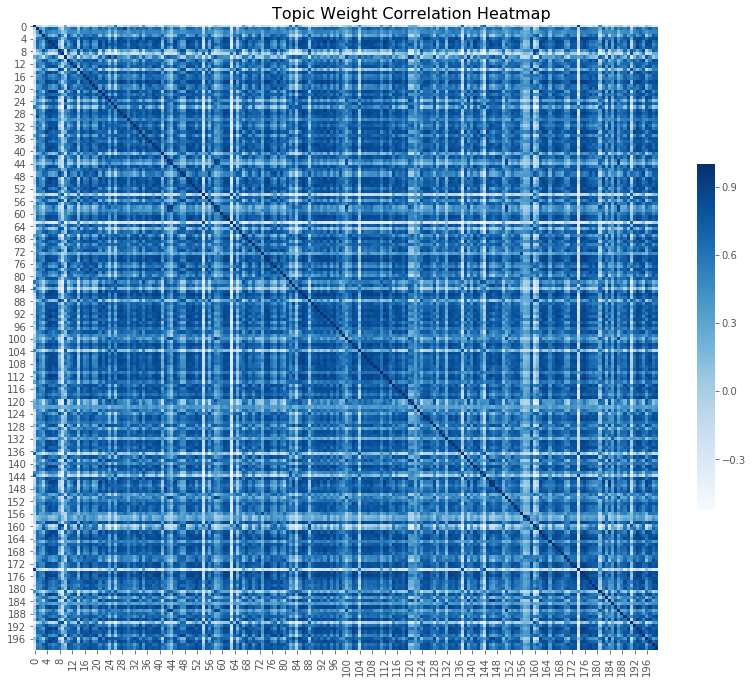

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=(14,11))

g = sns.heatmap(corr, 
                ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                cmap=plt.cm.Blues, # Color Map.
                cbar=True,
                cbar_kws={"shrink": .5},
                square=True,     # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                annot=False 
                #fmt='.2f',       # String formatting code to use when adding annotations.
                #annot_kws={"size": 14},
                #linewidths=.05
               )

fig.subplots_adjust(top=1)
fig.suptitle('Topic Weight Correlation Heatmap', 
              fontsize=16) 

**List the highest positive 10 correlation pairs:**

In [11]:
df_corr = df.corr().unstack().sort_values(kind='quicksort', ascending=False)
df_corr_p = pd.DataFrame(df_corr[200:210]).reset_index()
df_corr_p.columns = ['pair1', 'pair2', 'corr']
df_corr_p.T

,0,1,2,3,4,5,6,7,8,9
pair1,176,86,193,176,86,18,86,75,193,186
pair2,86,176,176,193,18,86,75,86,186,193
corr,0.967361,0.967361,0.947132,0.947132,0.946231,0.946231,0.944981,0.944981,0.943938,0.943938


In [12]:
topic_list = list(set(df_corr_p.pair1.unique()).union(set(df_corr_p.pair2.unique())))

print('The highest {} correlated topics: {}'.format(len(topic_list), topic_list))

The highest 6 correlated topics: ['86', '193', '176', '186', '75', '18']


**Plot pairwise plots:**

Text(0.5, 0.98, 'Topic Pairwise Plots')

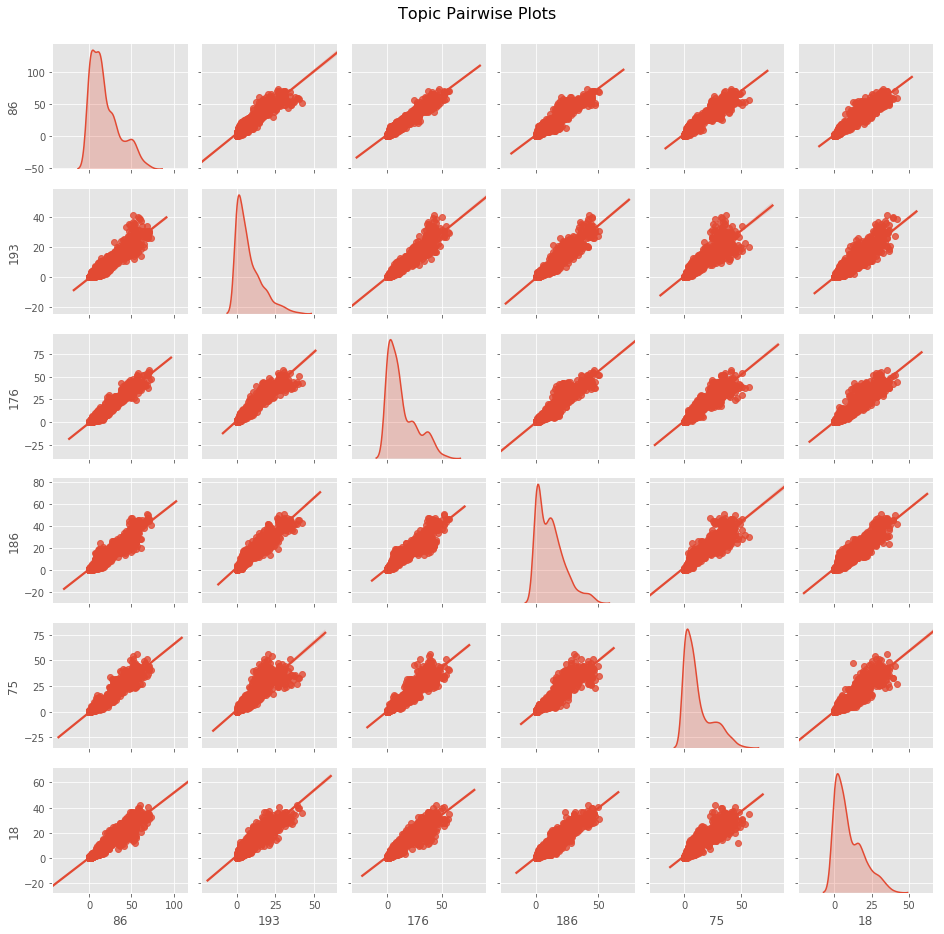

In [13]:
g = sns.pairplot(df[topic_list], 
                 diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                 diag_kind="kde",           # use "kde" for diagonal plots
                 height=2.2,
                 aspect=1,
                 kind="reg")                # linear regression to the scatter plots

fig = g.fig 
fig.subplots_adjust(top=0.94, wspace=0.1)
fig.suptitle('Topic Pairwise Plots', fontsize=16)

**List the highest negative 10 correlation pairs:**

In [14]:
df_corr = df.corr().unstack().sort_values(kind='quicksort', ascending=True)
df_corr_n = pd.DataFrame(df_corr[:10]).reset_index()
df_corr_n.columns = ['pair1', 'pair2', 'corr']
df_corr_n.T

,0,1,2,3,4,5,6,7,8,9
pair1,144,191,63,143,191,174,26,63,137,191
pair2,191,144,143,63,174,191,63,26,191,137
corr,-0.527432,-0.527432,-0.512923,-0.512923,-0.511694,-0.511694,-0.508702,-0.508702,-0.507812,-0.507812


In [15]:
topic_list = list(set(df_corr_n.pair1.unique()).union(set(df_corr_n.pair2.unique())))

print('The highest {} correlated topics: {}'.format(len(topic_list), topic_list))

The highest 7 correlated topics: ['174', '137', '191', '144', '63', '143', '26']


**Plot pairwise plots:**

Text(0.5, 0.98, 'Topic Pairwise Plots')

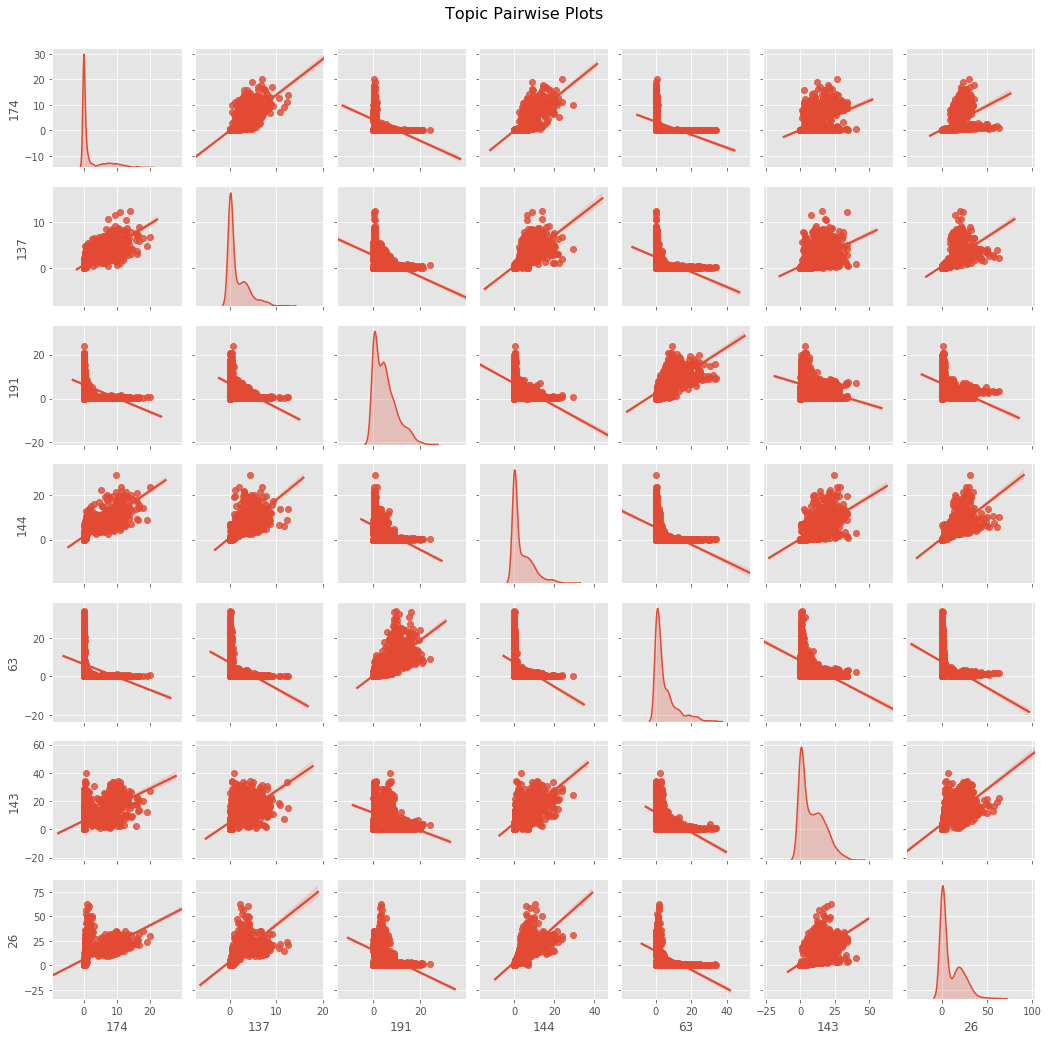

In [16]:
g = sns.pairplot(df[topic_list], 
                 diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                 diag_kind="kde",           # use "kde" for diagonal plots
                 height=2.1,
                 aspect=1,
                 kind="reg")                # linear regression to the scatter plots

fig = g.fig 
fig.subplots_adjust(top=0.94, wspace=0.1)
fig.suptitle('Topic Pairwise Plots', fontsize=16)

## 4 Linear Regression

**From above plot we see the negative correlations are ambiguous, while positive correlations are strong. We select one pair of them to perform a very simple linear regression.**

In [44]:
#pair = [int(x) for x in list(df_corr_p.iloc[0][0:2])]
pair = list(df_corr_p.iloc[0][0:2])
print('Topics pair to perform linear regression:', pair)

Topics pair to perform linear regression: ['176', '86']


In [45]:
df_topics[df_topics['topic'].isin(pair)].head()

,topic,weight,keywords
86,86,0.02881,time good present made great work fact large year number doubt place make years long past position matter success co...
176,176,0.01663,people man men good time money country work day make years great business things pay thing life find put poor


In [50]:
x = (df.iloc[:, int(pair[0])].values).reshape(-1, 1)
y = df.iloc[:, int(pair[1])].values

In [51]:
# gen dataset
x = (df.loc[:, pair[0]].values).reshape(-1, 1)
y = df.loc[:, pair[1]].values

# Split the dataset into the training set and test set
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 1)

# model
lr = LinearRegression()

# training
lr.fit(xTrain, yTrain)

# predicting
yPred = lr.predict(xTest)

# The coefficients
print('Coefficients: \n', lr.coef_)

# The mean squared error
print("Mean squared error: {:.2f}".format(mean_squared_error(yTest, yPred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: {:.2f}'.format(r2_score(yTest, yPred)))

Coefficients: 
 [1.26494246]
Mean squared error: 18.27
Variance score: 0.94


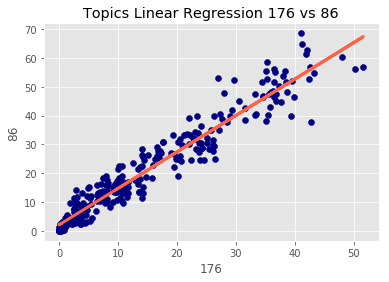

In [56]:
# Plot outputs
plt.scatter(xTest, yTest,  color='navy')
plt.plot(xTest, yPred, color='tomato', linewidth=3)

plt.grid(True)
plt.title('Topics Linear Regression {} vs {}'.format(pair[0], pair[1]))
plt.xlabel(pair[0])
plt.ylabel(pair[1])
plt.show()

**The range of time may affect the regression a lot, in small period time the correlation between topics may appear stronger than the whole time range.**

**By applying regression on topics, we have more change to find interesting patterns or features in topics.**

---

In [55]:
gc.collect()

8396